## Importing necessary libraries

In [1]:
import os
import xml.etree.cElementTree as ET
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from keras.utils import load_img,img_to_array
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.utils import plot_model
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import multilabel_confusion_matrix,classification_report,roc_curve,precision_recall_curve,auc,average_precision_score
from functools import partial,update_wrapper
from tensorflow.keras.models import load_model

## Data visualization and Preprocessing

In [2]:
#Loading the data
imgs=[]
classification=dict()
for xml_file in os.listdir('VOC12_train/Annotations/'):
        xml_path=os.path.join('VOC12_train/Annotations/',xml_file)
        xml_tree = ET.parse(xml_path)
        root = xml_tree.getroot()
        imgname = root.find('filename').text
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)
        imgs.append(imgname)
        classification[imgname]=list(set(labels))

In [3]:
def plot_images(directory,set_name,num_images):
    selected_imgs=random.sample(imgs,num_images)
    plt.figure(figsize=(15,10))
    for i,img in enumerate(selected_imgs,1):
        img_path=os.path.join(directory,img)
        image=plt.imread(img_path)
        label=classification[img]
        plt.subplot(3, 4, i)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

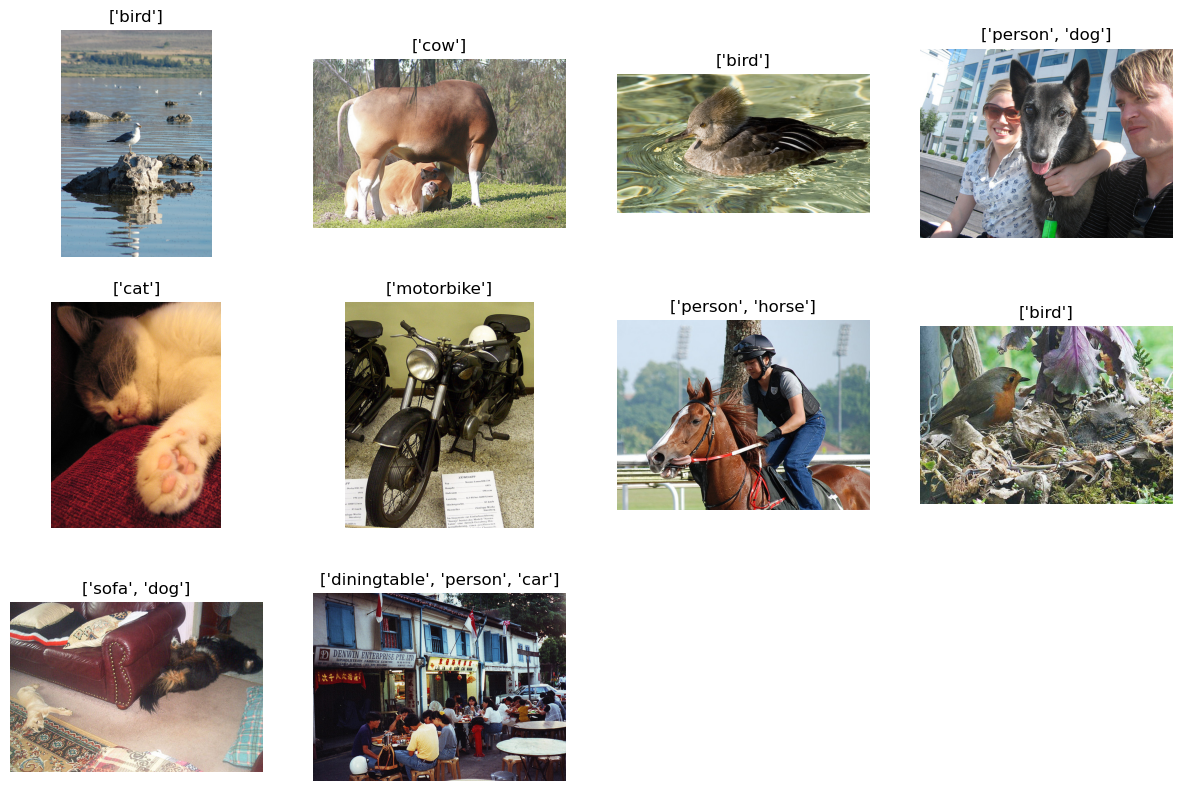

In [4]:
plot_images('VOC12_train/JPEGImages/','train',10)

In [5]:
#Converting labels into one hot encoding
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(classification.values())

In [6]:
#Creating a dataframe with image_names and there labels
df_train = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
df_train.insert(0, 'Image', imgs)
df_train.head()

Image  aeroplane  bicycle  bird  boat  bottle  bus  car  cat  \
0  2007_000027.jpg          0        0     0     0       0    0    0    0   
1  2007_000032.jpg          1        0     0     0       0    0    0    0   
2  2007_000033.jpg          1        0     0     0       0    0    0    0   
3  2007_000039.jpg          0        0     0     0       0    0    0    0   
4  2007_000042.jpg          0        0     0     0       0    0    0    0   

   chair  ...  diningtable  dog  horse  motorbike  person  pottedplant  sheep  \
0      0  ...            0    0      0          0       1            0      0   
1      0  ...            0    0      0          0       1            0      0   
2      0  ...            0    0      0          0       0            0      0   
3      0  ...            0    0      0          0       0            0      0   
4      0  ...            0    0      0          0       0            0      0   

   sofa  train  tvmonitor  
0     0      0          0  
1     0      0          0  
2     0      0          0  
3     0      0          1  
4     0      1          0  

[5 rows x 21 columns]

In [7]:
count_dict_train=dict()
for col in df_train.columns[1:]:
    count_dict_train[col]=df_train[col].values.sum()

In [8]:
def plot_class_distribution(count_dict,set_name):
    plot_df=pd.DataFrame(count_dict,index=[set_name])
    plot_df.T.plot(kind='bar')

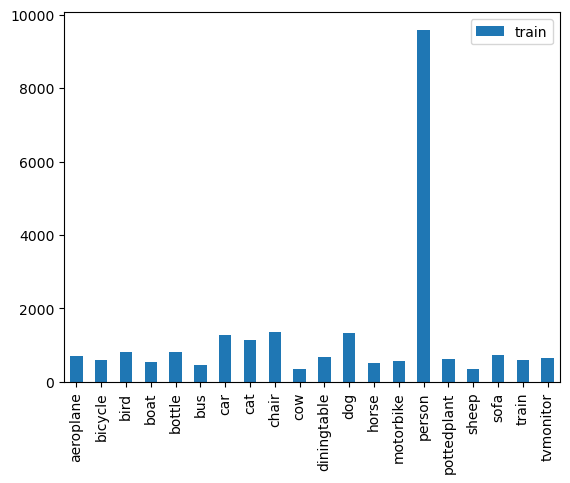

In [9]:
#Plotting distributuion of classes in our dataset
plot_class_distribution(count_dict_train,'train')

### Data augmentation code 

In [10]:
# Dont Run the code below,all the required files have been provided in the repo

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image
# aug_dir='aug/'
# aug_df=df_train.loc[(df_train['person']==0).values]
# img_to_aug=aug_df['Image'].values
# aug_image_data={}
# datagen=ImageDataGenerator(
#     rotation_range=25,
#     horizontal_flip=True,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     fill_mode='nearest'
# )
# for i in range(len(img_to_aug)):
#     label=aug_df[aug_df['Image']==img_to_aug[i]].drop(columns='Image').values[0]
#     img_path=os.path.join('VOC12_train/JPEGImages',img_to_aug[i])
#     img=image.load_img(img_path)
#     x=image.img_to_array(img)
#     x=x.reshape((1,)+x.shape)
#     j=0
#     for batch in datagen.flow(x,batch_size=1,save_to_dir=aug_dir,save_prefix=f'{img_to_aug[i][:-4]}',save_format='jpeg'):
#         aug_img_name=f'{img_to_aug[i]}_aug_{j}.jpeg'
#         aug_image_data[aug_img_name]=label
#         j+=1
#         if j>=2:
#             break
# new_names=[]
# for new_name in aug_image_data.keys():
#     new_names.append(new_name)
# print(new_names)
# old_names=os.listdir('aug/')
# for old_name, new_name in zip(old_names, new_names):
#         # Get the full path of the old and new files
#         old_path = os.path.join('aug2/', old_name)
#         new_path = os.path.join('aug2/', new_name)
#         # Rename the file
#         os.rename(old_path, new_path)
#         print(f"Renamed '{old_name}' to '{new_name}'.")
# for img_nam in os.listdir('aug/'):
#     if 'aug' not in img_nam:
#         print(img_nam)
# final_aug_df=pd.DataFrame.from_dict(aug_image_data,orient='index',columns=df_train.columns[1:])
# final_aug_df.head()
# final_aug_df.reset_index(inplace=True)
# final_aug_df.rename(columns={'index':'Image'},inplace=True)
# final_aug_df.head()
# final_train_df=pd.concat([df_train,final_aug_df],ignore_index=True)
# final_train_df_shuffled=final_train_df.sample(frac=1)
# final_train_df.to_csv('final_train_df.csv')


### We can cleary see there is imbalance withing each class as well as between classes<br>
<ul>
    <li>In each class majority sample are of negative class</li>
    <li>Between classes the person class has significantly more training examples than other classes</li>
</ul>
<ul>
    <li>To handle the first type of imbalance we will use a custom loss function to give weights to the positive instances withing each class</li>
    <li> To handle the seconf type of imbalance we will use data augmentation and try to add more data for other classes</li>
</ul>

In [11]:
final_train_df=pd.read_csv('final_train_df.csv')
final_train_df.head()

Unnamed: 0            Image  aeroplane  bicycle  bird  boat  bottle  bus  \
0           0  2007_000027.jpg          0        0     0     0       0    0   
1           1  2007_000032.jpg          1        0     0     0       0    0   
2           2  2007_000033.jpg          1        0     0     0       0    0   
3           3  2007_000039.jpg          0        0     0     0       0    0   
4           4  2007_000042.jpg          0        0     0     0       0    0   

   car  cat  ...  diningtable  dog  horse  motorbike  person  pottedplant  \
0    0    0  ...            0    0      0          0       1            0   
1    0    0  ...            0    0      0          0       1            0   
2    0    0  ...            0    0      0          0       0            0   
3    0    0  ...            0    0      0          0       0            0   
4    0    0  ...            0    0      0          0       0            0   

   sheep  sofa  train  tvmonitor  
0      0     0      0          0  
1      0     0      0          0  
2      0     0      0          0  
3      0     0      0          1  
4      0     0      1          0  

[5 rows x 22 columns]

In [12]:
final_train_df.drop(columns=['Unnamed: 0'],inplace=True)
final_train_df.head()

Image  aeroplane  bicycle  bird  boat  bottle  bus  car  cat  \
0  2007_000027.jpg          0        0     0     0       0    0    0    0   
1  2007_000032.jpg          1        0     0     0       0    0    0    0   
2  2007_000033.jpg          1        0     0     0       0    0    0    0   
3  2007_000039.jpg          0        0     0     0       0    0    0    0   
4  2007_000042.jpg          0        0     0     0       0    0    0    0   

   chair  ...  diningtable  dog  horse  motorbike  person  pottedplant  sheep  \
0      0  ...            0    0      0          0       1            0      0   
1      0  ...            0    0      0          0       1            0      0   
2      0  ...            0    0      0          0       0            0      0   
3      0  ...            0    0      0          0       0            0      0   
4      0  ...            0    0      0          0       0            0      0   

   sofa  train  tvmonitor  
0     0      0          0  
1     0      0          0  
2     0      0          0  
3     0      0          1  
4     0      1          0  

[5 rows x 21 columns]

In [13]:
final_train_df=final_train_df.sample(frac=1)
final_train_df.head()

Image  aeroplane  bicycle  bird  boat  bottle  \
3368              2008_005269.jpg          0        0     0     0       0   
28478  2010_003337.jpg_aug_1.jpeg          0        0     0     0       0   
22905  2009_000887.jpg_aug_0.jpeg          1        0     0     0       0   
21567  2008_007662.jpg_aug_0.jpeg          0        0     0     0       0   
43                2007_000661.jpg          0        0     0     0       0   

       bus  car  cat  chair  ...  diningtable  dog  horse  motorbike  person  \
3368     0    0    0      0  ...            0    0      0          0       0   
28478    0    0    1      0  ...            0    1      0          0       0   
22905    0    0    0      0  ...            0    0      0          0       0   
21567    0    0    1      0  ...            0    0      0          0       0   
43       0    0    0      1  ...            0    0      0          0       0   

       pottedplant  sheep  sofa  train  tvmonitor  
3368             0      0     0      1          0  
28478            0      0     0      0          0  
22905            0      0     0      0          0  
21567            0      0     0      0          0  
43               1      0     1      0          0  

[5 rows x 21 columns]

In [14]:
final_train_df=final_train_df.reset_index().drop(columns=['index'])

In [15]:
final_train_df.head()

Image  aeroplane  bicycle  bird  boat  bottle  bus  \
0             2008_005269.jpg          0        0     0     0       0    0   
1  2010_003337.jpg_aug_1.jpeg          0        0     0     0       0    0   
2  2009_000887.jpg_aug_0.jpeg          1        0     0     0       0    0   
3  2008_007662.jpg_aug_0.jpeg          0        0     0     0       0    0   
4             2007_000661.jpg          0        0     0     0       0    0   

   car  cat  chair  ...  diningtable  dog  horse  motorbike  person  \
0    0    0      0  ...            0    0      0          0       0   
1    0    1      0  ...            0    1      0          0       0   
2    0    0      0  ...            0    0      0          0       0   
3    0    1      0  ...            0    0      0          0       0   
4    0    0      1  ...            0    0      0          0       0   

   pottedplant  sheep  sofa  train  tvmonitor  
0            0      0     0      1          0  
1            0      0     0      0          0  
2            0      0     0      0          0  
3            0      0     0      0          0  
4            1      0     1      0          0  

[5 rows x 21 columns]

### Data distribution after data augmentation

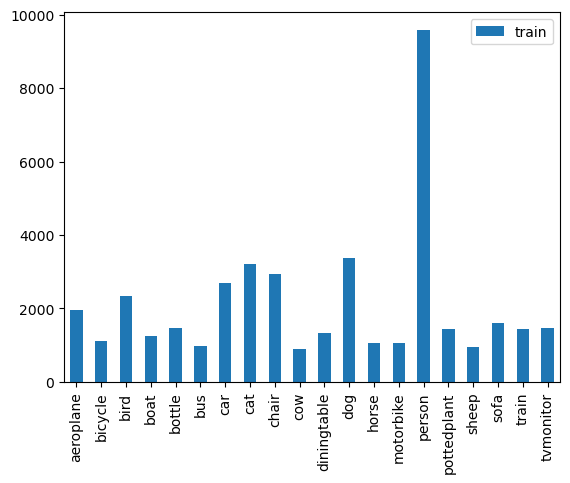

In [16]:
count_dict_train_final=dict()
for col in final_train_df.columns[1:]:
    count_dict_train_final[col]=final_train_df[col].values.sum()
plot_class_distribution(count_dict_train_final,'train')

In [17]:
#Loading and preprocessing the training data
X=[]
for img_name in final_train_df['Image'].values:
    if 'aug' in img_name:
        img_path=os.path.join('aug2/',img_name)
    else:
        img_path=os.path.join('VOC12_train/JPEGImages/',img_name)
        print(img_name)
    load_img=cv2.imread(img_path)
    load_img=cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
    load_img=load_img.astype(np.float32) / 255.0
    load_img = cv2.resize(load_img, (100,100))
    X.append(load_img)
X=np.array(X)

2008_005269.jpg
2007_000661.jpg
2010_003680.jpg
2008_006900.jpg
2010_002587.jpg
2010_004646.jpg
2008_005297.jpg
2009_004183.jpg
2009_004779.jpg
2009_004829.jpg
2012_000821.jpg
2011_001066.jpg
2010_003509.jpg
2009_004786.jpg
2011_003449.jpg
2008_007748.jpg
2009_005190.jpg
2010_006214.jpg
2009_000536.jpg
2011_005572.jpg
2012_003142.jpg
2008_002804.jpg
2008_003008.jpg
2010_000193.jpg
2009_002713.jpg
2012_004107.jpg
2008_008031.jpg
2011_005709.jpg
2009_004652.jpg
2008_008453.jpg
2011_005907.jpg
2010_006462.jpg
2008_005166.jpg
2010_003304.jpg
2008_003873.jpg
2008_006625.jpg
2008_000828.jpg
2009_003361.jpg
2008_001590.jpg
2009_004723.jpg
2008_007746.jpg
2009_004402.jpg
2010_006815.jpg
2010_003942.jpg
2007_004468.jpg
2012_003614.jpg
2011_006890.jpg
2011_004839.jpg
2008_002067.jpg
2011_000007.jpg
2008_003776.jpg
2008_001529.jpg
2010_002713.jpg
2009_002910.jpg
2009_004007.jpg
2011_006039.jpg
2011_002606.jpg
2010_004073.jpg
2007_005797.jpg
2010_000323.jpg
2008_002446.jpg
2012_000142.jpg
2009_000

In [18]:
y=final_train_df.drop(columns='Image')
y.head()

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  \
0          0        0     0     0       0    0    0    0      0    0   
1          0        0     0     0       0    0    0    1      0    0   
2          1        0     0     0       0    0    0    0      0    0   
3          0        0     0     0       0    0    0    1      0    0   
4          0        0     0     0       0    0    0    0      1    0   

   diningtable  dog  horse  motorbike  person  pottedplant  sheep  sofa  \
0            0    0      0          0       0            0      0     0   
1            0    1      0          0       0            0      0     0   
2            0    0      0          0       0            0      0     0   
3            0    0      0          0       0            0      0     0   
4            0    0      0          0       0            1      0     1   

   train  tvmonitor  
0      1          0  
1      0          0  
2      0          0  
3      0          0  
4      0          0

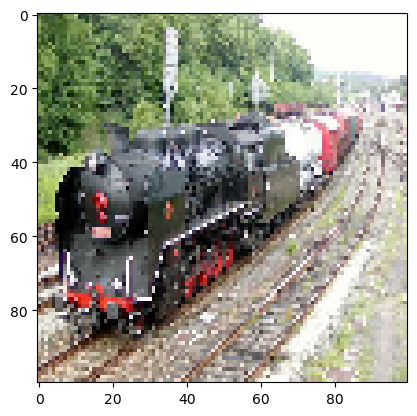

In [19]:
plt.imshow(X[0])

In [20]:
# Performing training and validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [21]:
X.shape

(32207, 100, 100, 3)

In [22]:
count_dict_train_final={}
count_dict_val={}
for col in y_train.columns[0:]:
    count_dict_train_final[col]=y_train[col].values.sum()
for col in y_val.columns[0:]:
    count_dict_val[col]=y_val[col].values.sum()

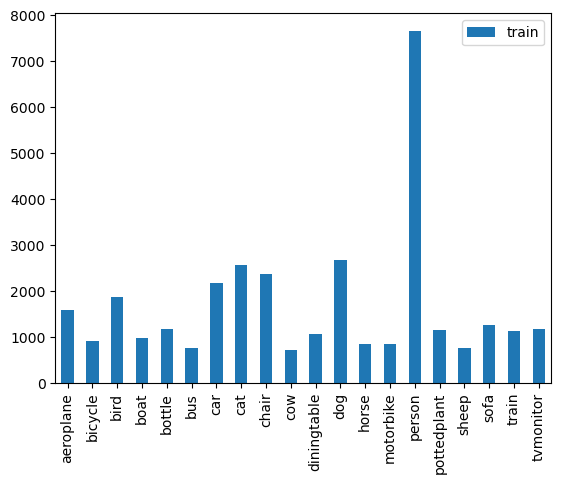

In [23]:
#Training dataset distribution
plot_class_distribution(count_dict_train_final,'train')

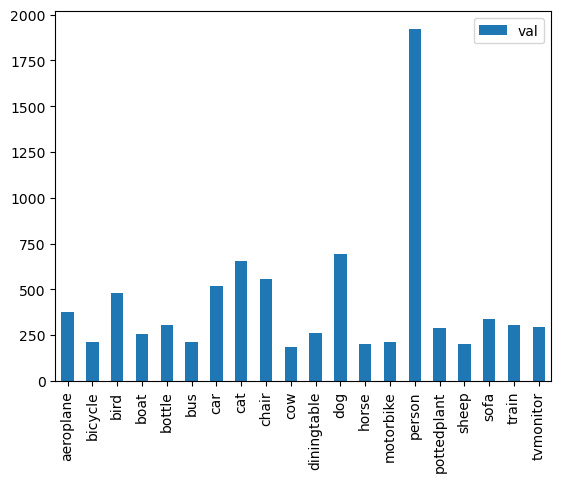

In [24]:
#Validation dataset distribution
plot_class_distribution(count_dict_val,'val')

In [25]:
#Loading and preprocessing testdata
imgs_test=[]
classification_test=dict()
for xml_file in os.listdir('VOC12_test/Annotations/'):
        xml_path=os.path.join('VOC12_test/Annotations/',xml_file)
        xml_tree = ET.parse(xml_path)
        root = xml_tree.getroot()
        imgname = root.find('filename').text
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(label)
        imgs_test.append(imgname)
        classification_test[imgname]=list(set(labels))
mlb_test = MultiLabelBinarizer()
one_hot_encoded_labels_test = mlb_test.fit_transform(classification_test.values())
df_test = pd.DataFrame(one_hot_encoded_labels_test, columns=mlb_test.classes_)
df_test.insert(0, 'Image', imgs_test)
df_test.head()
X_test=[]
for img_name in imgs_test:
    img_path=os.path.join('VOC12_test/JPEGImages/',img_name)
    load_img=cv2.imread(img_path)
    load_img=cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
    load_img=load_img.astype(np.float32) / 255.0
    load_img = cv2.resize(load_img, (100,100))
    X_test.append(load_img)
X_test=np.array(X_test)
y_test=df_test.drop(columns='Image')
y_test.head()

chair  diningtable  person
0      0            0       1
1      0            0       1
2      0            0       1
3      0            0       1
4      0            0       1

In [26]:
y_test[['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']]=0
y_test=y_test[['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']]

## Defining the custom loss function

In [27]:
#custom loss function
def weighted_binary_crossentropy(y_train):
    """A weighted binary crossentropy loss function
    that works for multilabel classification
    """
    # obtain dataset here
    data = y_train.values
    # create a 2 by N array with weights for 0's and 1's
    weights = np.zeros((2, data.shape[1]))
    # calculates weights for each label in a for loop
    for i in range(data.shape[1]):
        weights_n, weights_p = (data.shape[0]/(2 * (data[:,i] == 0).sum())), (data.shape[0]/(2 * (data[:,i] == 1).sum()))
        # weights could be log-dampened to avoid extreme weights for extremly unbalanced data.
        weights[1, i], weights[0, i] = weights_p, weights_n

    # The below is needed to be able to work with keras' model.compile()
    def wrapped_partial(func, *args, **kwargs):
        partial_func = partial(func, *args, **kwargs)
        update_wrapper(partial_func, func)
        return partial_func

    def wrapped_weighted_binary_crossentropy(y_true, y_pred, class_weights):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
        y_true=K.cast(y_true, y_pred.dtype)
	# cross-entropy loss with weighting
        out = -(y_true * K.log(y_pred)*class_weights[1] + (1.0 - y_true) * K.log(1.0 - y_pred)*class_weights[0])

        return K.mean(out, axis=-1)

    return wrapped_partial(wrapped_weighted_binary_crossentropy, class_weights=weights)

In [28]:
custom_loss = weighted_binary_crossentropy(y_train)

## VGG16

In [29]:
#VGG net
tf.keras.backend.clear_session()
# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [30]:
#Freezing weights of all layers except the last 4
for layer in vgg.layers[:-4]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [31]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with sigmoid activation
output = Dense(20, activation='sigmoid', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss=custom_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=[tf.keras.metrics.AUC(curve='PR'),'accuracy'])

# Model summary to see all layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [32]:
cnn_path = 'models/'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_auc')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_auc',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          restore_best_weights=True,
                          mode='max')

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              mode='max')

# Aggregating all callbacks into a list
callbacks = [checkpoint,earlystop,reduce_lr]


In [33]:
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=64,callbacks=callbacks)

Epoch 1/50
403/403 [==============================] - ETA: 0s - loss: 0.5556 - auc: 0.2267 - accuracy: 0.2247
Epoch 1: val_auc improved from -inf to 0.42845, saving model to models\VGG16_Transfer_Learning.keras
403/403 [==============================] - 52s 96ms/step - loss: 0.5556 - auc: 0.2267 - accuracy: 0.2247 - val_loss: 0.4077 - val_auc: 0.4284 - val_accuracy: 0.4519 - lr: 1.0000e-04
Epoch 2/50
402/403 [============================>.] - ETA: 0s - loss: 0.4162 - auc: 0.4074 - accuracy: 0.4127
Epoch 2: val_auc improved from 0.42845 to 0.53225, saving model to models\VGG16_Transfer_Learning.keras
403/403 [==============================] - 30s 74ms/step - loss: 0.4161 - auc: 0.4074 - accuracy: 0.4128 - val_loss: 0.3607 - val_auc: 0.5323 - val_accuracy: 0.5090 - lr: 1.0000e-04
Epoch 3/50
402/403 [============================>.] - ETA: 0s - loss: 0.3507 - auc: 0.5205 - accuracy: 0.4998
Epoch 3: val_auc improved from 0.53225 to 0.56270, saving model to models\VGG16_Transfer_Learning.ker

In [35]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

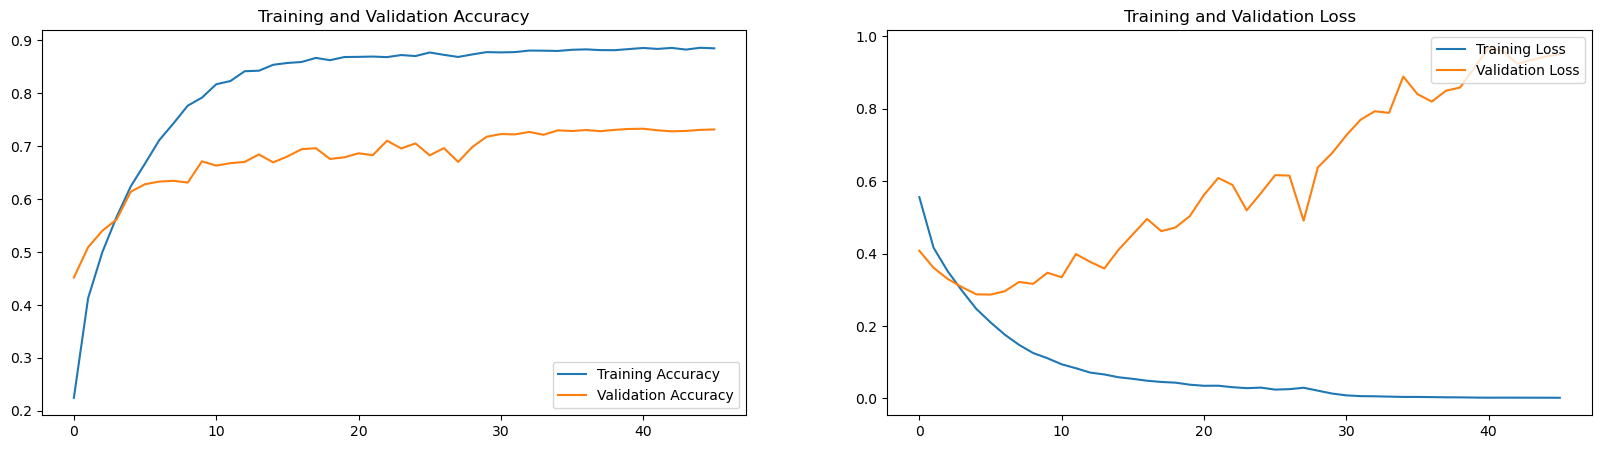

In [35]:
plot_training_history(history)

In [36]:
classes = np.array(df_train.columns[1:])
y_pred_val = model.predict(X_val)
top_3_pred_val=[]
for pred in y_pred_val:
    top_3_pred_val.append(np.argsort(pred)[:-4:-1])

202/202 [==============================] - 6s 27ms/step


### Now we use precision-recall curves to find optimal threshold(threshold with max f1-score for a particular class) to further enhance the predictions made by our model

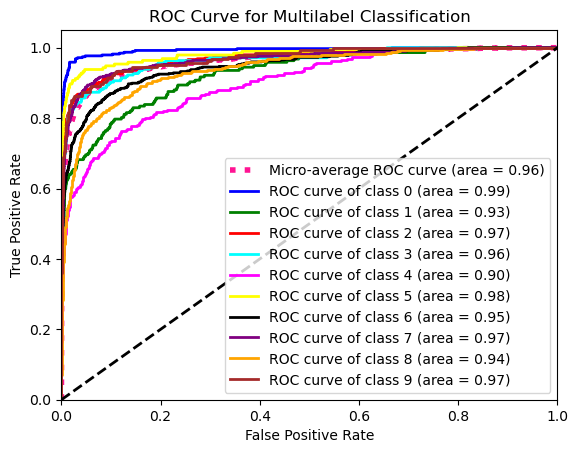

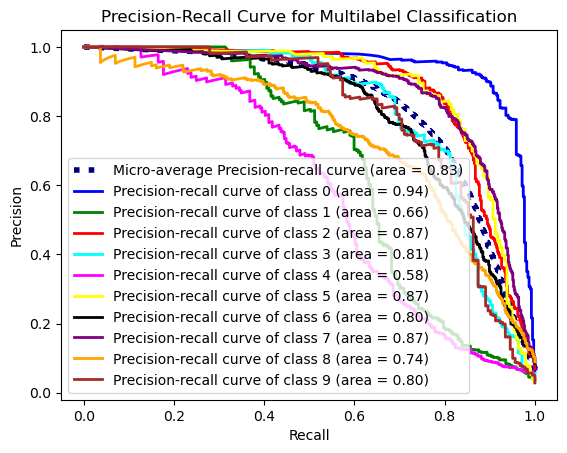

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(20):
    fpr[i], tpr[i], _ = roc_curve(y_val.values[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val.values.ravel(), y_pred_val.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure()
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']
for i, color in zip(range(20), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
threshold=dict()
average_precision = dict()
for i in range(20):
    precision[i], recall[i],threshold[i] = precision_recall_curve(y_val.values[:, i], y_pred_val[:, i])
    average_precision[i] = average_precision_score(y_val.values[:, i],y_pred_val[:, i])

# Compute micro-average precision-recall curve and average precision
precision_micro, recall_micro, _ = precision_recall_curve(y_val.values.ravel(), y_pred_val.ravel())
average_precision_micro = average_precision_score(y_val.values, y_pred_val, average="micro")

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_micro, precision_micro, label='Micro-average Precision-recall curve (area = {0:0.2f})'
         ''.format(average_precision_micro),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(20), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Multilabel Classification')
plt.legend(loc="lower left")
plt.show()

In [38]:
#Classification Report with 0.5 as threshold for each class
y_pred_val_ohe=(y_pred_val >= 0.5).astype(int)
print(classification_report(y_val,y_pred_val_ohe))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       389
           1       0.61      0.63      0.62       217
           2       0.75      0.84      0.79       447
           3       0.70      0.79      0.74       245
           4       0.50      0.58      0.54       261
           5       0.74      0.85      0.79       194
           6       0.68      0.76      0.72       546
           7       0.80      0.81      0.80       613
           8       0.63      0.76      0.69       574
           9       0.75      0.72      0.73       183
          10       0.56      0.70      0.63       240
          11       0.69      0.85      0.76       666
          12       0.59      0.70      0.64       219
          13       0.71      0.73      0.72       233
          14       0.81      0.87      0.84      1967
          15       0.64      0.66      0.65       295
          16       0.76      0.80      0.78       186
          17       0.58    

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
#Finding optimal threshold for each class
best_thresh=[]
for i in range(20):
    fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix = np.argmax(fscore)
    best_thresh.append(threshold[i][ix])
best_thresh=np.array(best_thresh)

In [40]:
best_thresh

array([0.9764347 , 0.86700374, 0.9580185 , 0.97607523, 0.8924771 ,
       0.83733904, 0.77580863, 0.807935  , 0.59751046, 0.8219376 ,
       0.95550644, 0.9573971 , 0.9788937 , 0.54718715, 0.8936326 ,
       0.5472825 , 0.6532899 , 0.73689383, 0.9159378 , 0.96371144],
      dtype=float32)

In [41]:
y_pred_val_final=(y_pred_val>best_thresh).astype(int)

In [42]:
print(classification_report(y_val,y_pred_val_final))#Classification report using optimal thresholds

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       389
           1       0.74      0.59      0.66       217
           2       0.87      0.79      0.82       447
           3       0.85      0.69      0.76       245
           4       0.68      0.51      0.58       261
           5       0.84      0.80      0.82       194
           6       0.76      0.72      0.74       546
           7       0.85      0.78      0.82       613
           8       0.65      0.74      0.69       574
           9       0.82      0.69      0.75       183
          10       0.75      0.59      0.66       240
          11       0.80      0.77      0.79       666
          12       0.77      0.63      0.69       219
          13       0.71      0.72      0.72       233
          14       0.88      0.81      0.85      1967
          15       0.65      0.65      0.65       295
          16       0.78      0.79      0.79       186
          17       0.63    

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
y_test_pred_prob=model.predict(X_test)

161/161 [==============================] - 6s 38ms/step


In [44]:
y_test_pred=(y_test_pred_prob>=best_thresh).astype(int)

In [45]:
print(classification_report(y_test.values,y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       1.00      0.86      0.93      5138
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
y_test_pred=mlb.inverse_transform(y_test_pred)

In [47]:
y_test_pred

[('person',),
 ('dog',),
 ('chair', 'person'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('chair', 'person'),
 ('person',),
 ('boat', 'person'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('train',),
 ('person',),
 ('bird',),
 ('person',),
 ('person',),
 ('person',),
 ('bottle', 'chair', 'person'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('chair', 'pottedplant'),
 ('chair',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('chair', 'diningtable'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('motorbike', 'person'),
 ('person',),
 ('person',),
 ('p

1/1 [==============================] - 0s 23ms/step


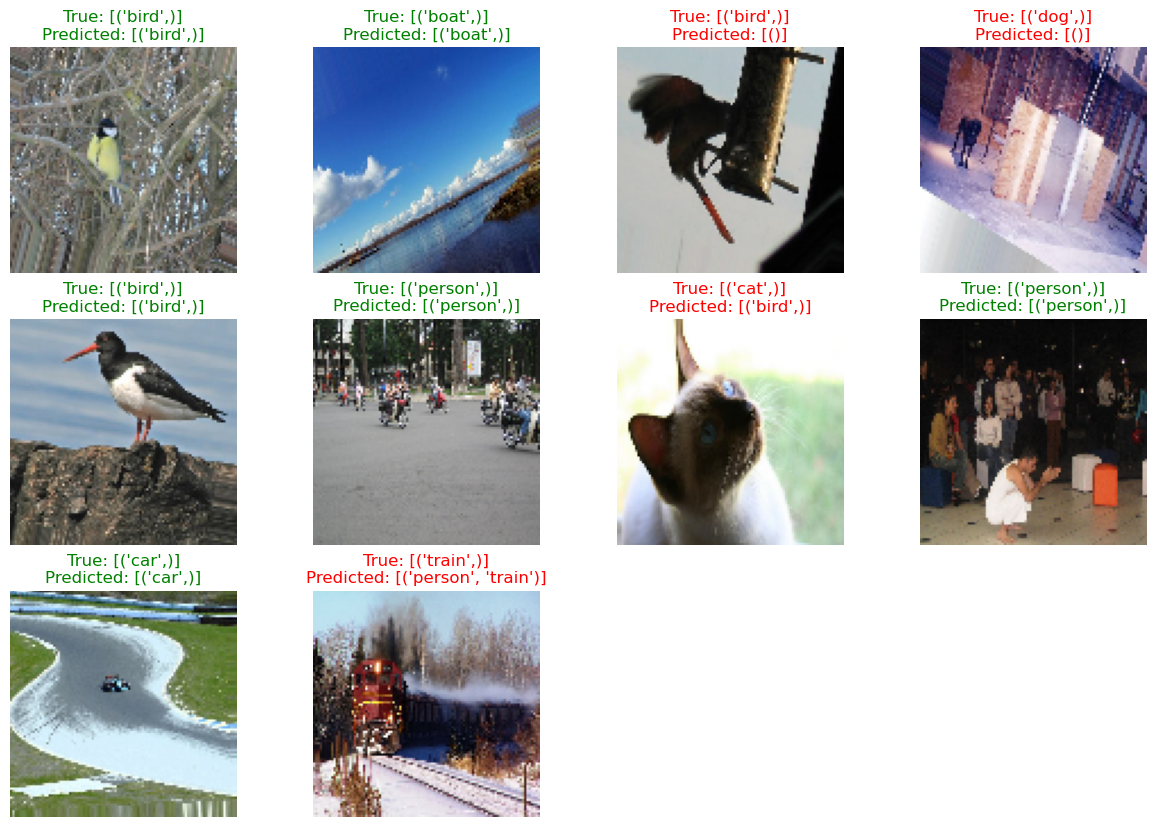

In [48]:
#Visualizing predictions on some images in validation dataset
random_img_index=np.random.randint(0,6442,10)
plt.figure(figsize=(15,10))
for i,img_index in enumerate(random_img_index):
    img=X_val[img_index]
    y_pred=model.predict(np.expand_dims(img,axis=0))[0]
    y_pred=(y_pred>=best_thresh).astype(int)
    y_pred=mlb.inverse_transform(np.array([(y_pred)]))
    y_actual=mlb.inverse_transform(np.array([(y_val.values[img_index])]))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    color = "green" if y_pred == y_actual else "red"
    plt.title(f"True: {y_actual}\nPredicted: {y_pred}", color=color)
    plt.axis('off')
    

## ResNet

In [29]:
##Resnet
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(100, 100, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )
ResNet50V2.trainable = True
for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(20,activation='sigmoid')
                    ])
    return model


In [30]:
model2 = Create_ResNet50V2_Model()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [31]:
model2.compile(optimizer='adam', loss=custom_loss, metrics=[tf.keras.metrics.AUC(curve='PR'),'accuracy'])

In [32]:
cnn_path = 'models/'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_auc')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_auc',
                          patience = 15,
                          restore_best_weights = True,
                          verbose=1,
                          mode='max')

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr]  # Adjusted as per your use-case

In [33]:
history2=model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=64,callbacks=callbacks)

Epoch 1/50
403/403 [==============================] - ETA: 0s - loss: 0.5212 - auc: 0.2978 - accuracy: 0.3651
Epoch 1: val_auc improved from -inf to 0.32837, saving model to models\ResNet50_Transfer_Learning.keras
403/403 [==============================] - 37s 67ms/step - loss: 0.5212 - auc: 0.2978 - accuracy: 0.3651 - val_loss: 0.5520 - val_auc: 0.3284 - val_accuracy: 0.3712 - lr: 0.0010
Epoch 2/50
402/403 [============================>.] - ETA: 0s - loss: 0.3866 - auc: 0.4687 - accuracy: 0.5017
Epoch 2: val_auc improved from 0.32837 to 0.57442, saving model to models\ResNet50_Transfer_Learning.keras
403/403 [==============================] - 24s 60ms/step - loss: 0.3866 - auc: 0.4686 - accuracy: 0.5018 - val_loss: 0.3364 - val_auc: 0.5744 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 3/50
402/403 [============================>.] - ETA: 0s - loss: 0.3136 - auc: 0.5753 - accuracy: 0.5806
Epoch 3: val_auc improved from 0.57442 to 0.58282, saving model to models\ResNet50_Transfer_Learning.ke

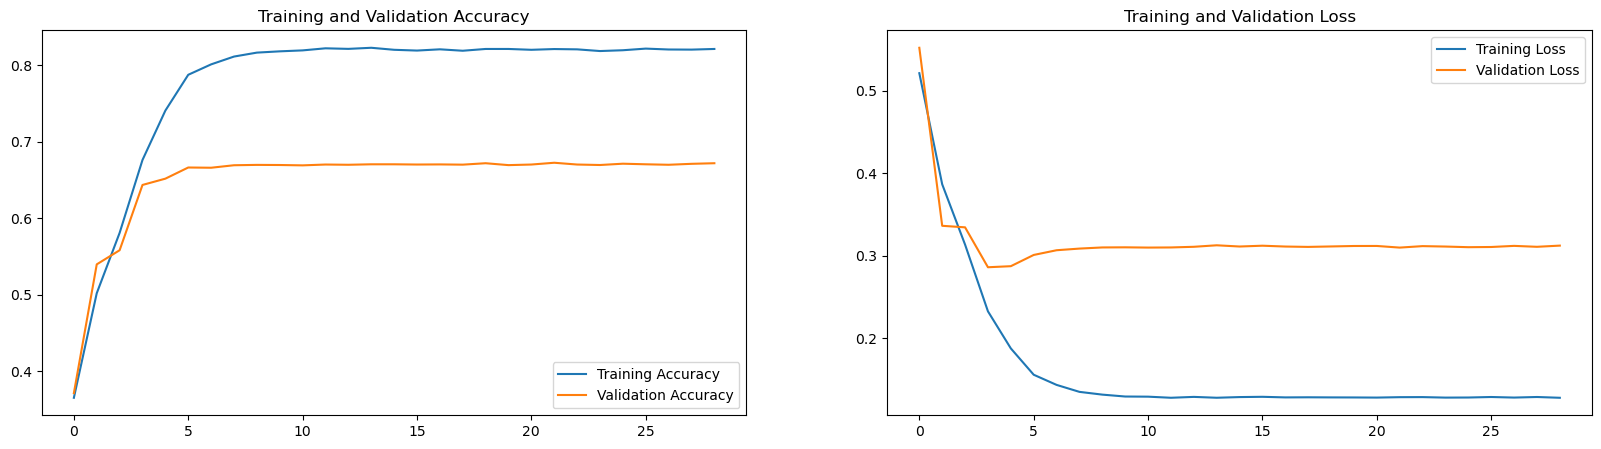

In [36]:
plot_training_history(history2)

In [37]:
classes = np.array(df_train.columns[1:])
y_pred_val = model2.predict(X_val)
top_3_pred_val=[]
for pred in y_pred_val:
    top_3_pred_val.append(np.argsort(pred)[:-4:-1])

202/202 [==============================] - 6s 21ms/step


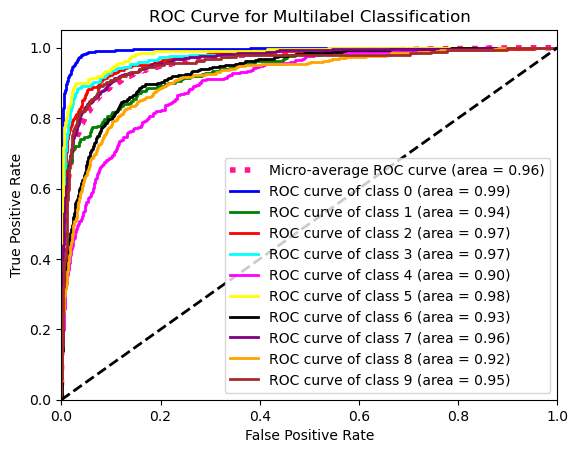

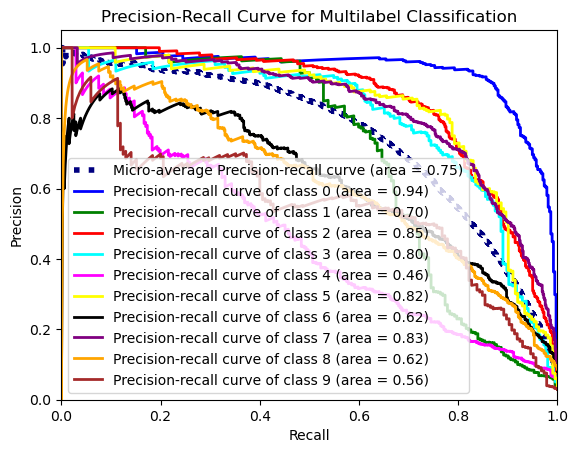

In [38]:
# Assuming y_pred and y_true are numpy arrays of shape (num_samples, num_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(20):
    fpr[i], tpr[i], _ = roc_curve(y_val.values[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val.values.ravel(), y_pred_val.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure()
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']
for i, color in zip(range(20), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
threshold=dict()
average_precision = dict()
for i in range(20):
    precision[i], recall[i],threshold[i] = precision_recall_curve(y_val.values[:, i], y_pred_val[:, i])
    average_precision[i] = average_precision_score(y_val.values[:, i],y_pred_val[:, i])

# Compute micro-average precision-recall curve and average precision
precision_micro, recall_micro, _ = precision_recall_curve(y_val.values.ravel(), y_pred_val.ravel())
average_precision_micro = average_precision_score(y_val.values, y_pred_val, average="micro")

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_micro, precision_micro, label='Micro-average Precision-recall curve (area = {0:0.2f})'
         ''.format(average_precision_micro),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(20), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Multilabel Classification')
plt.legend(loc="lower left")
plt.show()

In [39]:
y_pred_val_ohe=(y_pred_val >= 0.5).astype(int)
print(classification_report(y_val,y_pred_val_ohe))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       376
           1       0.46      0.72      0.56       212
           2       0.68      0.81      0.74       481
           3       0.60      0.85      0.70       255
           4       0.28      0.67      0.40       306
           5       0.59      0.88      0.70       212
           6       0.42      0.80      0.55       517
           7       0.58      0.86      0.69       653
           8       0.43      0.77      0.55       558
           9       0.40      0.81      0.54       185
          10       0.38      0.73      0.50       262
          11       0.49      0.81      0.61       693
          12       0.40      0.69      0.50       201
          13       0.42      0.78      0.54       210
          14       0.78      0.87      0.82      1922
          15       0.32      0.66      0.43       290
          16       0.50      0.74      0.60       200
          17       0.33    

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
best_thresh=[]
for i in range(20):
    fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    ix = np.argmax(fscore)
    best_thresh.append(threshold[i][ix])
best_thresh=np.array(best_thresh)

C:\Users\vinay\AppData\Local\Temp\ipykernel_11032\3560799536.py:3: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])


In [41]:
y_pred_val_final=(y_pred_val>best_thresh).astype(int)

In [42]:
print(classification_report(y_val,y_pred_val_final))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       376
           1       0.76      0.62      0.68       212
           2       0.82      0.75      0.78       481
           3       0.76      0.73      0.75       255
           4       0.49      0.45      0.47       306
           5       0.81      0.77      0.79       212
           6       0.00      0.00      0.00       517
           7       0.77      0.75      0.76       653
           8       0.00      0.00      0.00       558
           9       0.54      0.68      0.60       185
          10       0.59      0.53      0.56       262
          11       0.65      0.68      0.66       693
          12       0.58      0.55      0.57       201
          13       0.77      0.60      0.67       210
          14       0.85      0.81      0.83      1922
          15       0.42      0.51      0.46       290
          16       0.70      0.65      0.67       200
          17       0.58    

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
y_test_pred_prob2=model2.predict(X_test)
y_test_pred2=(y_test_pred_prob2>=best_thresh).astype(int)
print(classification_report(y_test.values,y_test_pred2))
y_test_pred2=mlb.inverse_transform(y_test_pred2)

161/161 [==============================] - 4s 22ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       1.00      0.88      0.94      5138
          15       0.00      0.00      0.00         0
          16       0.00  

C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinay\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
y_test_pred2

[('person',),
 ('person',),
 ('bottle', 'person'),
 ('horse', 'person'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('pottedplant', 'sofa'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('train',),
 ('person',),
 ('bird',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('dog', 'person'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('cat', 'dog', 'sofa'),
 ('bottle', 'person'),
 ('person',),
 (),
 (),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person', 'tvmonitor'),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 ('person',),
 (

1/1 [==============================] - 0s 44ms/step


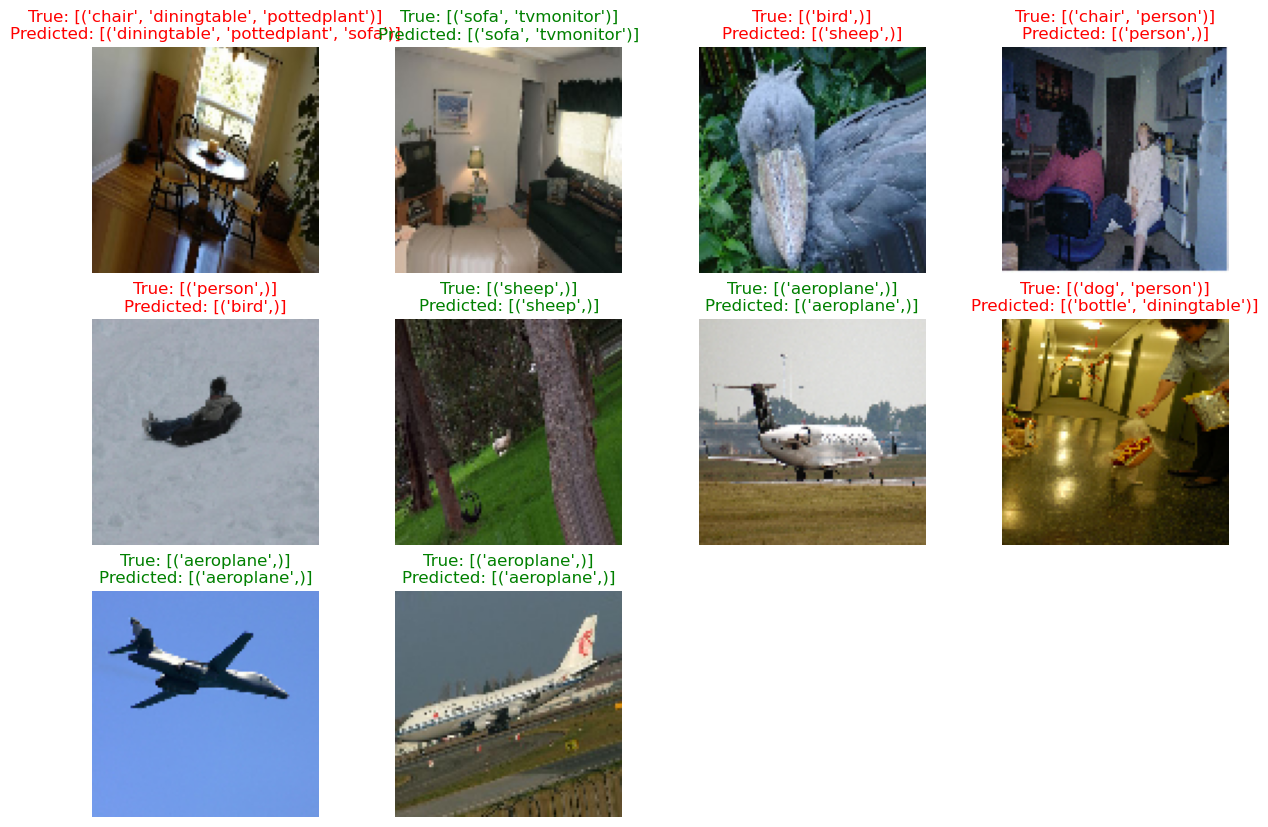

In [45]:
#Visualizing predictions on some images in validation dataset
random_img_index=np.random.randint(0,6442,10)
plt.figure(figsize=(15,10))
for i,img_index in enumerate(random_img_index):
    img=X_val[img_index]
    y_pred=model2.predict(np.expand_dims(img,axis=0))[0]
    y_pred=(y_pred>=best_thresh).astype(int)
    y_pred=mlb.inverse_transform(np.array([(y_pred)]))
    y_actual=mlb.inverse_transform(np.array([(y_val.values[img_index])]))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    color = "green" if y_pred == y_actual else "red"
    plt.title(f"True: {y_actual}\nPredicted: {y_pred}", color=color)
    plt.axis('off')
    